In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
import itertools

import xgboost as xgb
from sklearn import model_selection
from xgboost.sklearn import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

C:\Users\Barshu\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def str_to_date(date):
    return datetime.strptime(date, '%Y-%m-%d').date()

In [3]:
df_train = pd.read_csv(r'C:\Users\Barshu\OneDrive\Desktop\DataSet\train.csv',sep=',', parse_dates=['Date']
                       , date_parser=str_to_date,
                       low_memory = False)
df_store = pd.read_csv(r'C:\Users\Barshu\OneDrive\Desktop\DataSet\store.csv')

In [4]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
df_train.info()
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store      

In [7]:
df_store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


## Data Wrangling and Exploration 

In [8]:
#missing_values in training data 
df_train.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [9]:
df_train=df_train.drop(df_train[(df_train.Open == 0) & (df_train.Sales == 0)].index)
df_train = df_train.reset_index(drop=True)

In [10]:
#dropping the sales with alues =  0,where there was no sales at all even if the store was open
df_train=df_train.drop(df_train[(df_train.Open == 1) & (df_train.Sales == 0)].index)
df_train = df_train.reset_index(drop=True)

In [11]:
df_train.Sales.describe() 

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

(46.0, 41551.0)

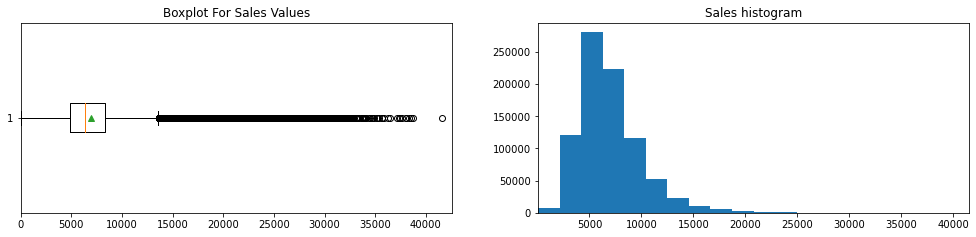

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(df_train.Sales, showmeans=True,vert=False)
axes[0].set_xlim(0,max(df_train["Sales"]+1000))
axes[0].set_title('Boxplot For Sales Values')
axes[1].hist(df_train.Sales, cumulative=False, bins=20)
axes[1].set_title("Sales histogram")
axes[1].set_xlim((min(df_train.Sales), max(df_train.Sales)))

In [13]:
df_train.Customers.describe()

count    844338.000000
mean        762.777166
std         401.194153
min           8.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64

(8.0, 7388.0)

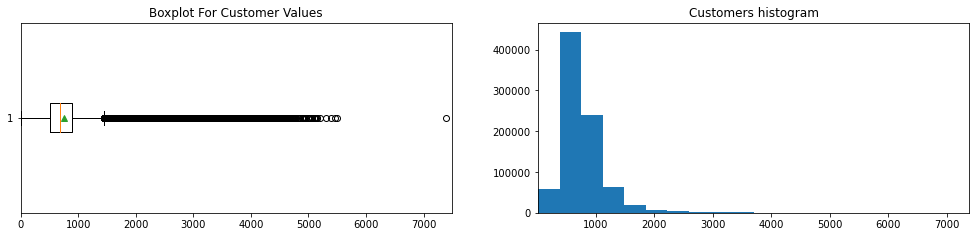

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(df_train.Customers, showmeans=True,vert=False)
axes[0].set_xlim(0,max(df_train["Customers"]+100))
axes[0].set_title('Boxplot For Customer Values')
axes[1].hist(df_train.Customers, cumulative=False, bins=20)
axes[1].set_title("Customers histogram")
axes[1].set_xlim((min(df_train.Customers), max(df_train.Customers)))

In [15]:
#missing_values in store data 
df_store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [16]:
#fill_rate in store data
df_store.count(0)/df_store.shape[0] * 100

Store                        100.000000
StoreType                    100.000000
Assortment                   100.000000
CompetitionDistance           99.730942
CompetitionOpenSinceMonth     68.251121
CompetitionOpenSinceYear      68.251121
Promo2                       100.000000
Promo2SinceWeek               51.210762
Promo2SinceYear               51.210762
PromoInterval                 51.210762
dtype: float64

In [17]:
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace = True)
df_store.CompetitionOpenSinceMonth.fillna(0, inplace = True)
df_store.CompetitionOpenSinceYear.fillna(0,inplace=True)
df_store.Promo2SinceWeek.fillna(0,inplace=True)
df_store.Promo2SinceYear.fillna(0,inplace=True)
df_store.PromoInterval.fillna(0,inplace=True)

In [18]:
df_store.count(0)/df_store.shape[0] * 100

Store                        100.0
StoreType                    100.0
Assortment                   100.0
CompetitionDistance          100.0
CompetitionOpenSinceMonth    100.0
CompetitionOpenSinceYear     100.0
Promo2                       100.0
Promo2SinceWeek              100.0
Promo2SinceYear              100.0
PromoInterval                100.0
dtype: float64

Since,all the missing values are filled,store dataset and training(sales) dataset can be  merged.

In [19]:
df_train_store = pd.merge(df_train, df_store, how = 'left', on = 'Store')
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


Let's add sales per costumer to know average sales per customer .

In [20]:
df_train_store['SalesperCustomer']=df_train_store['Sales']/df_train_store['Customers']
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,8.626118


**Analysis of the feature variables**

1. StoreType :

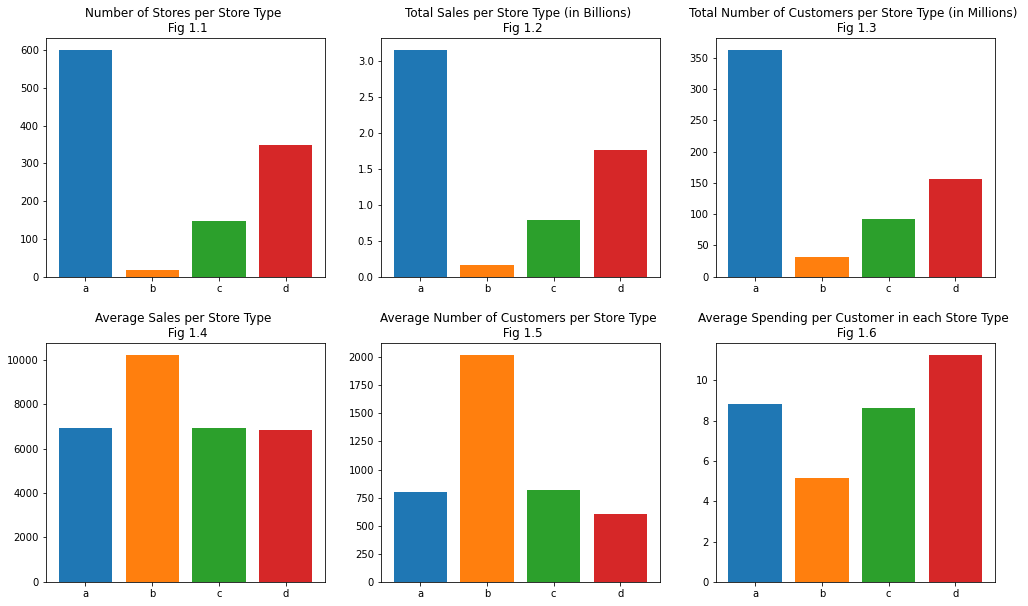

In [21]:
fig, axes = plt.subplots(2, 3,figsize=(17,10) )
palette = itertools.cycle(sns.color_palette(n_colors=4))
plt.subplots_adjust(hspace = 0.28)
#axes[1].df_train_store.groupby(by="StoreType").count().Store.plot(kind='bar')
axes[0,0].bar(df_store.groupby(by="StoreType").count().Store.index,df_store.groupby(by="StoreType").count().Store,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,0].set_title("Number of Stores per Store Type \n Fig 1.1")
axes[0,1].bar(df_train_store.groupby(by="StoreType").sum().Sales.index,df_train_store.groupby(by="StoreType").sum().Sales/1e9,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,1].set_title("Total Sales per Store Type (in Billions) \n Fig 1.2")
axes[0,2].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").sum().Customers/1e6,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,2].set_title("Total Number of Customers per Store Type (in Millions) \n Fig 1.3")
axes[1,0].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").Sales.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,0].set_title("Average Sales per Store Type \n Fig 1.4")
axes[1,1].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").Customers.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,1].set_title("Average Number of Customers per Store Type \n Fig 1.5")
axes[1,2].bar(df_train_store.groupby(by="StoreType").sum().Sales.index,df_train_store.groupby(by="StoreType").SalesperCustomer.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,2].set_title("Average Spending per Customer in each Store Type \n Fig 1.6")
plt.show()

**Analysis :**

1. Storetype A has the highest number of branches,sales and customers among the 4 different storetypes.
2. Eventhough,Storetype B has least number of stores,it has the highest average sales and average customers .
3. Storetype D has the highest average spending per customer.

**2. Assortments:**

There are 3 types of assortments:

a : basic products 
b : extra products along with basic products
c : extended products with the highest variety of products

StoreType  Assortment
a          a             381
           c             221
b          a               7
           b               9
           c               1
c          a              77
           c              71
d          a             128
           c             220
Name: Assortment, dtype: int64

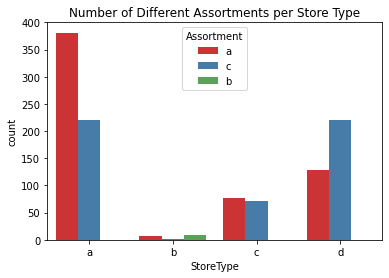

In [22]:
StoretypeXAssortment = sns.countplot(x="StoreType",hue="Assortment",order=["a","b","c","d"], data=df_store,palette=sns.color_palette("Set1", n_colors=3)).set_title("Number of Different Assortments per Store Type")
df_store.groupby(by=["StoreType","Assortment"]).Assortment.count()

**Analysis :**

1. Most of the stores have either assortment type A or C.
2. Since, store type D has more stores with ,assortment type C ,it could be the reason for having the highest average spending per customer.
3. Since, store type B is the only store with assortment type b, it has drawn the highest numbers of customers. 

**3. Promotions :**

C:\Users\Barshu\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


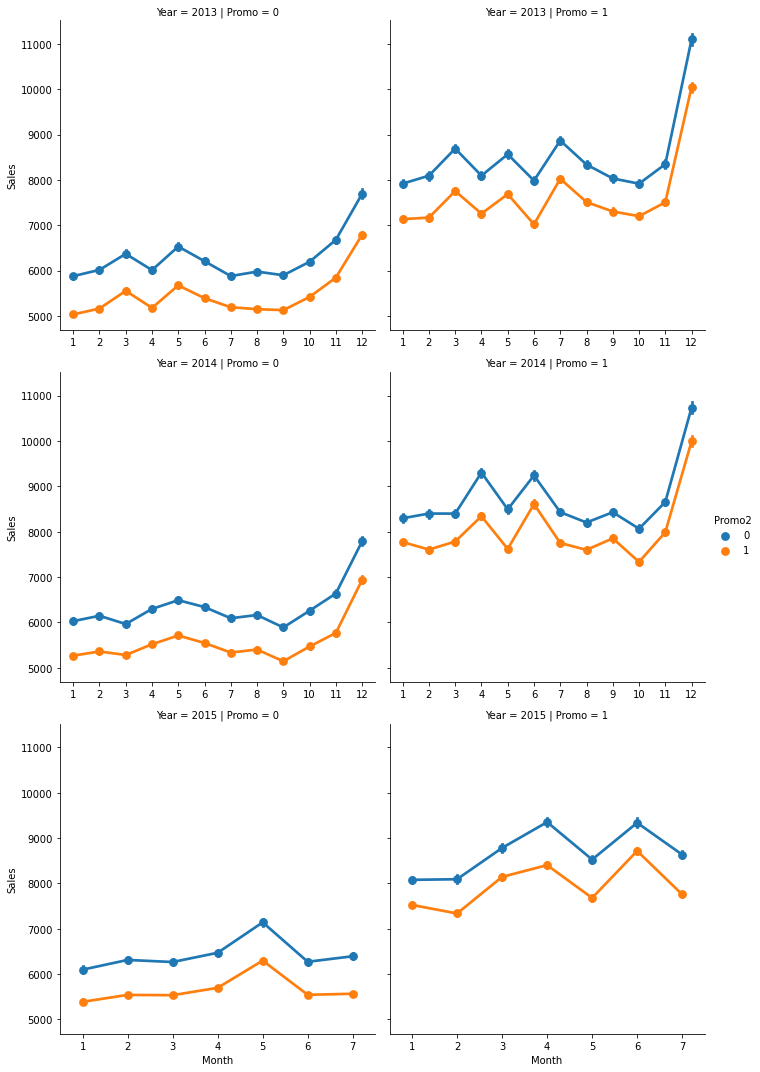

In [24]:
df_train_store['Month']=df_train_store.Date.dt.month
df_train_store['Year']=df_train_store.Date.dt.year
sns.factorplot(data = df_train_store, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year"
              ,sharex=False)

**Analysis :**

Store having promotion has better number of sales

**4. Competition Distance:**

In [26]:
df_train_store['CompetitionDist_Cat']=pd.cut(df_train_store['CompetitionDistance'], 5)
# changing continuous variable into categorical with 5 categories
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer,Month,Year,CompetitionDist_Cat
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,0.0,0.0,0,9.482883,7,2015,"(-55.84, 15188.0]"
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400,7,2015,"(-55.84, 15188.0]"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675,7,2015,"(-55.84, 15188.0]"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,0.0,0.0,0,9.342457,7,2015,"(-55.84, 15188.0]"
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,0.0,0.0,0,8.626118,7,2015,"(15188.0, 30356.0]"


In [27]:
df_train_store.groupby(by="CompetitionDist_Cat").Sales.mean(),df_train_store.groupby(by="CompetitionDist_Cat").Customers.mean()

(CompetitionDist_Cat
 (-55.84, 15188.0]     6957.360876
 (15188.0, 30356.0]    7041.604692
 (30356.0, 45524.0]    6471.923562
 (45524.0, 60692.0]    5980.114445
 (60692.0, 75860.0]    7775.446449
 Name: Sales, dtype: float64,
 CompetitionDist_Cat
 (-55.84, 15188.0]     771.345223
 (15188.0, 30356.0]    691.574605
 (30356.0, 45524.0]    680.101854
 (45524.0, 60692.0]    643.988246
 (60692.0, 75860.0]    914.574972
 Name: Customers, dtype: float64)

**Analysis :**

Greater the distance of competitor's stores, higher the average sales and number of customers.

**Correlation Analysis:** 

In [29]:
df_train_store.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'SalesperCustomer', 'Month', 'Year',
       'CompetitionDist_Cat'],
      dtype='object')

In [30]:
del df_train_store["CompetitionDist_Cat"]
df_train_store['Day']=df_train_store.Date.dt.day
del df_train_store["Date"]

In [32]:
df_train_store["StoreType"].value_counts(),df_train_store["Assortment"].value_counts(),df_train_store["StateHoliday"].value_counts()

(a    457042
 d    258768
 c    112968
 b     15560
 Name: StoreType, dtype: int64,
 a    444875
 c    391254
 b      8209
 Name: Assortment, dtype: int64,
 0    843428
 a       694
 b       145
 c        71
 Name: StateHoliday, dtype: int64)

In [33]:
df_train_store['StateHoliday'] = df_train_store['StateHoliday'].astype('category')
df_train_store['Assortment'] = df_train_store['Assortment'].astype('category')
df_train_store['StoreType'] = df_train_store['StoreType'].astype('category')
df_train_store['PromoInterval']= df_train_store['PromoInterval'].astype('category')
df_train_store['StateHoliday_cat'] = df_train_store['StateHoliday'].cat.codes
df_train_store['Assortment_cat'] = df_train_store['Assortment'].cat.codes
df_train_store['StoreType_cat'] = df_train_store['StoreType'].cat.codes
df_train_store['PromoInterval_cat'] = df_train_store['PromoInterval'].cat.codes
df_train_store['StateHoliday_cat'] = df_train_store['StateHoliday_cat'].astype('float')
df_train_store['Assortment_cat'] = df_train_store['Assortment_cat'].astype('float')
df_train_store['StoreType_cat'] = df_train_store['StoreType_cat'].astype('float')
df_train_store['PromoInterval_cat'] = df_train_store['PromoInterval_cat'].astype('float')

In [35]:
df_train_store[['StateHoliday', 'StoreType', 'Assortment']] = df_train_store[['StateHoliday', 'StoreType', 'Assortment']].apply(lambda x: x.cat.codes)

In [36]:
df_train_store.dtypes

Store                           int64
DayOfWeek                       int64
Sales                           int64
Customers                       int64
Open                            int64
Promo                           int64
StateHoliday                     int8
SchoolHoliday                   int64
StoreType                        int8
Assortment                       int8
CompetitionDistance           float64
CompetitionOpenSinceMonth     float64
CompetitionOpenSinceYear      float64
Promo2                          int64
Promo2SinceWeek               float64
Promo2SinceYear               float64
PromoInterval                category
SalesperCustomer              float64
Month                           int64
Year                            int64
Day                             int64
StateHoliday_cat              float64
Assortment_cat                float64
StoreType_cat                 float64
PromoInterval_cat             float64
dtype: object

C:\Users\Barshu\AppData\Local\Temp\ipykernel_9672\2856698874.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triangle = np.zeros_like(df_correlation.corr(), dtype = np.bool)


<AxesSubplot:>

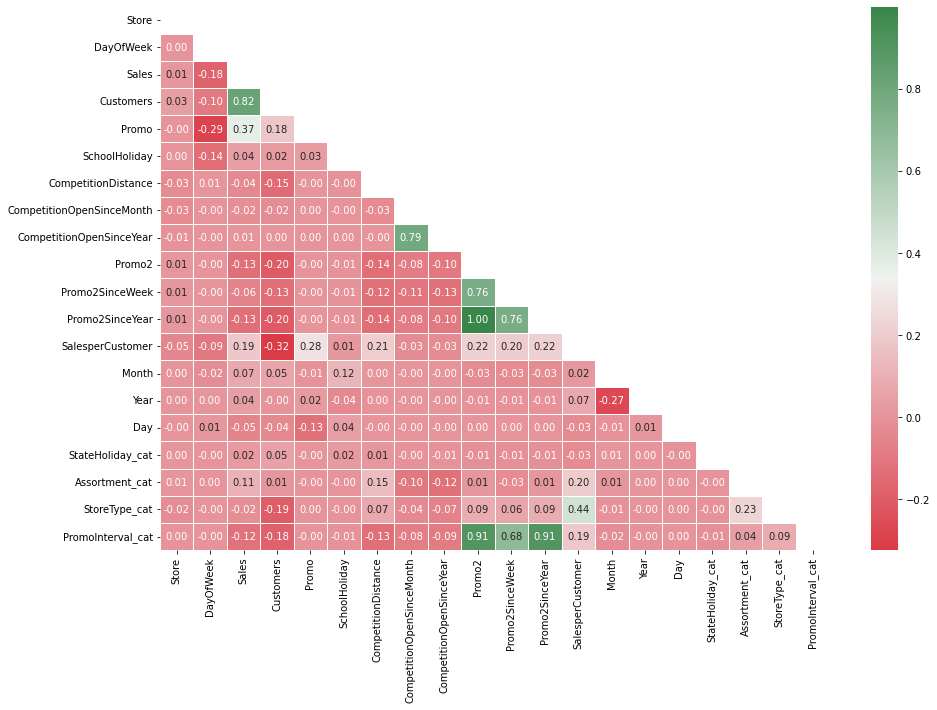

In [37]:
df_correlation=df_train_store[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
        'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'SalesperCustomer', 'Month', 'Year',
       'Day', 'StateHoliday_cat', 'Assortment_cat', 'StoreType_cat',
       'PromoInterval_cat']]
df_correlation=df_correlation.drop('Open', axis = 1)
upper_triangle = np.zeros_like(df_correlation.corr(), dtype = np.bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True #make sure we don't show half of the other triangle
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(df_correlation.corr(),ax=ax,mask=upper_triangle,annot=True, fmt='.2f',linewidths=0.5,cmap=sns.diverging_palette(10, 133, as_cmap=True))

**Training the model**

In [38]:
df_train_store.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'SalesperCustomer', 'Month', 'Year',
       'Day', 'StateHoliday_cat', 'Assortment_cat', 'StoreType_cat',
       'PromoInterval_cat'],
      dtype='object')

In [39]:
df_train_store['CompetitionOpenSince'] = np.where((df_train_store['CompetitionOpenSinceMonth']==0) & (df_train_store['CompetitionOpenSinceYear']==0) , 0,(df_train_store.Month - df_train_store.CompetitionOpenSinceMonth) + 
                                       (12 * (df_train_store.Year - df_train_store.CompetitionOpenSinceYear)) )

del df_train_store['CompetitionOpenSinceYear']
del df_train_store['CompetitionOpenSinceMonth']

In [40]:
df_train_store["is_holiday_state"] = df_train_store['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})
del df_train_store['StateHoliday_cat']

In [41]:
df_train_store=pd.get_dummies(df_train_store, columns=["Assortment", "StoreType","PromoInterval"], prefix=["is_Assortment", "is_StoreType","is_PromoInteval"])
del df_train_store['Assortment_cat']
del df_train_store['StoreType_cat']
del df_train_store['PromoInterval_cat']


In [42]:
df_train_store.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'SalesperCustomer', 'Month',
       'Year', 'Day', 'CompetitionOpenSince', 'is_holiday_state',
       'is_Assortment_0', 'is_Assortment_1', 'is_Assortment_2',
       'is_StoreType_0', 'is_StoreType_1', 'is_StoreType_2', 'is_StoreType_3',
       'is_PromoInteval_0', 'is_PromoInteval_Feb,May,Aug,Nov',
       'is_PromoInteval_Jan,Apr,Jul,Oct', 'is_PromoInteval_Mar,Jun,Sept,Dec'],
      dtype='object')

**Transfomation of test set**

In [43]:
df_test = pd.read_csv(r'C:\Users\Barshu\OneDrive\Desktop\DataSet\test.csv',sep=',', parse_dates=['Date']
                       , date_parser=str_to_date,
                       low_memory = False)

In [44]:
df_test.fillna(1, inplace = True)
df_test_store = pd.merge(df_test, df_store, how = 'left', on = 'Store')
print ("The Test_Store dataset has {} Rows and {} Variables".format(str(df_test_store.shape[0]),str(df_test_store.shape[1]))) 
df_test_store['Month']=df_test_store.Date.dt.month
df_test_store['Year']=df_test_store.Date.dt.year
df_test_store['Day']=df_test_store.Date.dt.day

df_test_store['StateHoliday'] = df_test_store['StateHoliday'].astype('category')
df_test_store['Assortment'] = df_test_store['Assortment'].astype('category')
df_test_store['StoreType'] = df_test_store['StoreType'].astype('category')
df_test_store['PromoInterval']= df_test_store['PromoInterval'].astype('category')
df_test_store['StateHoliday_cat'] = df_test_store['StateHoliday'].cat.codes
df_test_store['Assortment_cat'] = df_test_store['Assortment'].cat.codes
df_test_store['StoreType_cat'] = df_test_store['StoreType'].cat.codes
df_test_store['PromoInterval_cat'] = df_test_store['PromoInterval'].cat.codes
df_test_store['StateHoliday_cat'] = df_test_store['StateHoliday_cat'].astype('float')
df_test_store['Assortment_cat'] = df_test_store['Assortment_cat'].astype('float')
df_test_store['StoreType_cat'] = df_test_store['StoreType_cat'].astype('float')
df_test_store['PromoInterval_cat'] = df_test_store['PromoInterval_cat'].astype('float')
df_test_store['CompetitionOpenSince'] = np.where((df_test_store['CompetitionOpenSinceMonth']==0) & (df_test_store['CompetitionOpenSinceYear']==0) , 0,(df_test_store.Month - df_test_store.CompetitionOpenSinceMonth) + 
                                       (12 * (df_test_store.Year - df_test_store.CompetitionOpenSinceYear)) )



df_test_store["is_holiday_state"] = df_test_store['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})




df_test_store=pd.get_dummies(df_test_store, columns=["Assortment", "StoreType","PromoInterval"], prefix=["is_Assortment", "is_StoreType","is_PromoInteval"])

The Test_Store dataset has 41088 Rows and 17 Variables


In [45]:
del df_test_store["Date"]
del df_test_store['CompetitionOpenSinceYear']
del df_test_store['CompetitionOpenSinceMonth']
del df_test_store['StateHoliday_cat']
del df_test_store['Assortment_cat']
del df_test_store['StoreType_cat']
del df_test_store['PromoInterval_cat']
del df_test_store['StateHoliday']
del df_train_store['StateHoliday']

**Defining Function for performance metric**

In [46]:
def rmspe(y, yhat):
    rmspe = np.sqrt(np.mean( (y - yhat)**2 ))
    return rmspe

In [47]:
features = df_train_store.drop(['Customers', 'Sales', 'SalesperCustomer'], axis = 1) 

targets=np.log(df_train_store.Sales)

In [48]:
from sklearn.model_selection import train_test_split, cross_val_score

In [49]:
X_train, X_train_test, y_train, y_train_test = train_test_split(features, targets, test_size=0.20, random_state=15)

In [52]:
from xgboost import XGBRegressor

In [53]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)
model.fit(X_train, y_train)

C:\Users\Barshu\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

**Prediction**

In [54]:
predict = model.predict(X_train)

In [55]:
predict

array([8.434863, 8.692772, 8.979356, ..., 8.708004, 8.94999 , 8.609896],
      dtype=float32)

**Evaluation**

In [56]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [70]:
rmse(predict, y_train)

0.3225247407620133

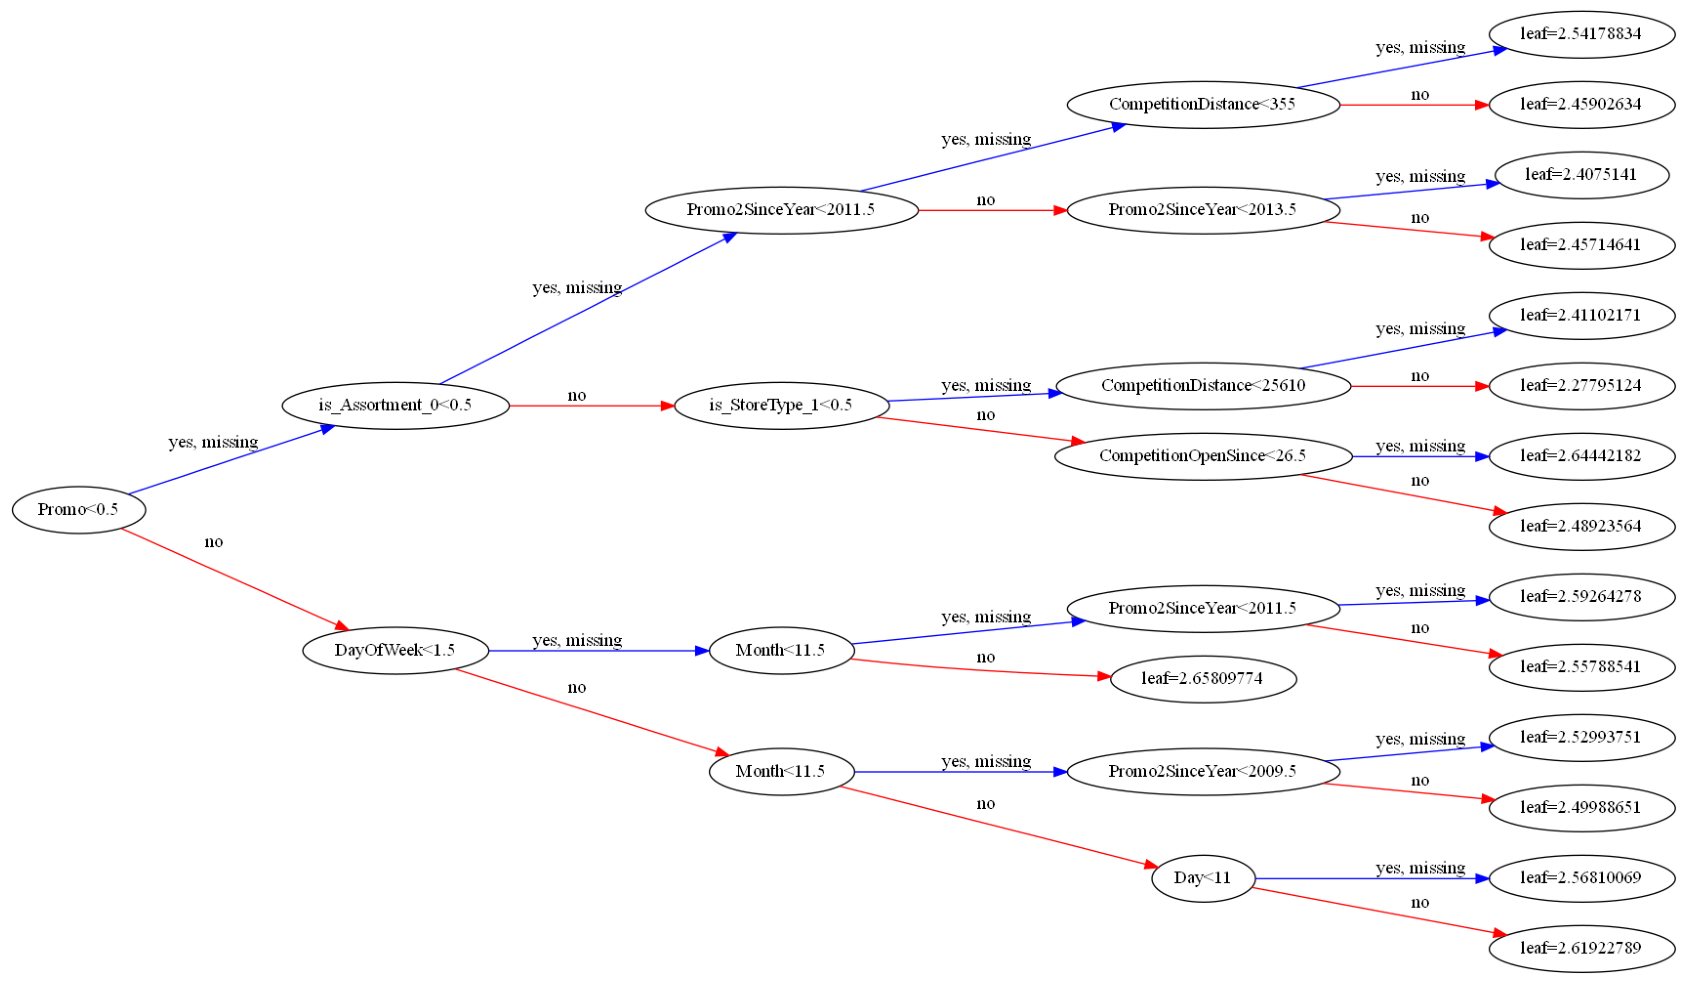

In [71]:
import os
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30
plot_tree(model, rankdir='LR');

In [61]:
trees = model.get_booster().get_dump()

In [62]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=1
	1:[is_Assortment_0<1] yes=3,no=4,missing=3
		3:[Promo2SinceYear<2011.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<355] yes=15,no=16,missing=15
				15:leaf=2.54178834
				16:leaf=2.45902634
			8:[Promo2SinceYear<2013.5] yes=17,no=18,missing=17
				17:leaf=2.4075141
				18:leaf=2.45714641
		4:[is_StoreType_1<1] yes=9,no=10,missing=9
			9:[CompetitionDistance<25610] yes=19,no=20,missing=19
				19:leaf=2.41102171
				20:leaf=2.27795124
			10:[CompetitionOpenSince<26.5] yes=21,no=22,missing=21
				21:leaf=2.64442182
				22:leaf=2.48923564
	2:[DayOfWeek<2] yes=5,no=6,missing=5
		5:[Month<12] yes=11,no=12,missing=11
			11:[Promo2SinceYear<2011.5] yes=23,no=24,missing=23
				23:leaf=2.59264278
				24:leaf=2.55788541
			12:leaf=2.65809774
		6:[Month<12] yes=13,no=14,missing=13
			13:[Promo2SinceYear<2009.5] yes=25,no=26,missing=25
				25:leaf=2.52993751
				26:leaf=2.49988651
			14:[Day<11] yes=27,no=28,missing=27
				27:leaf=2.56810069
				28:leaf=2.61922

In [64]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [1]:
importance_df.head(20)

NameError: name 'importance_df' is not defined

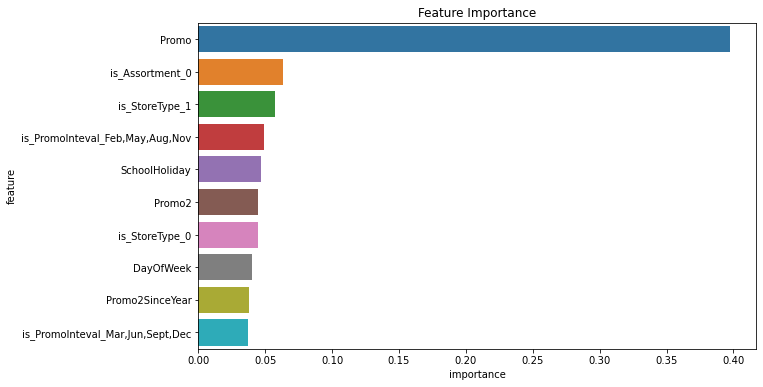

In [66]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');